! calls out to a shell (in a new process), while % affects the process associated with the notebook (or the notebook itself; many % commands have no shell counterpart).

!cd foo, by itself, has no lasting effect, since the process with the changed directory immediately terminates.

%cd foo changes the current directory of the notebook process, which is a lasting effect.


The exclamation mark (!) executes shell commands within a Jupyter Notebook cell when you type (!) followed by a shell command, Jupyter Notebook sends the command to the shell to run, on the other hand, the percent symbol (%) is used to execute special commands, called "magic commands", that are specific to Jupyter Notebook and not valid as shell commands for example:%matplotlib inline to enable inline plots.

However, % is also capable of sending shell commands like "ls", "cd" or "pip install" to the Juypter Notebook to execute. One difference I noticed as well is that In the latter case "pip install" will target the active virtual environment associated with the Jupyter Notebook kernel while if I do "!pip install" visual studio code will complain asking to use % in order for the packages to be installed to the right virtual environment.

https://stackoverflow.com/questions/45784499/what-is-the-difference-between-and-in-jupyter-notebooks

In [8]:
import numpy as np
from scipy.spatial.transform import Rotation

In [9]:
def Pi(x: np.array):
    """
    Converts homogeneous to inhomogeneous coordinates
    Args:
        x (np.array) homogeneous coordinate

    Return:
        np.array converted inhomogeneous coordinate
    """

    return x[:-1] / x[-1]

def Piinv(x: np.array):
    """
    Converts inhomogeneous to homogeneous coordinates

    Args:
        x (np.array) inhomogeneous coordinate

    Return:
        np.array converted homogeneous coordinate
    """
    if x.ndim == 1:
        return np.concatenate((x, np.ones(1)))
    return np.vstack((x, np.ones((1, x.shape[1]))))

## Epipolar geometry

![rotation](images/rotation.png)

In [10]:
K = np.asarray([[1000, 0 , 300], [0, 1000, 200], [0, 0, 1]])
R1 = np.eye(3)
t1 = np.zeros((3, 1))
R2 = Rotation.from_euler('xyz', [0.7, -0.5, 0.8]).as_matrix()
t2 = np.asarray([0.2, 2, 1]).reshape(3, 1)

## Ex 3.1

In [11]:
Q = np.asarray([1, 0.5, 4, 1]).reshape((4, 1))
P1 = np.concatenate((R1, t1), axis=1)
P2 = np.concatenate((R2, t2), axis=1)
q1 = K @ P1 @ Q
q2 = K @ P2 @ Q
Pi(q1), Pi(q2)

(array([[550.],
        [325.]]),
 array([[582.47256835],
        [185.98985776]]))

## Ex 3.2

In [12]:
def skew(x: np.array):
    """
    This function returns a numpy array with the skew symmetric cross product matrix for vector.
    the skew symmetric cross product matrix is defined such that
    np.cross(a, b) = np.dot(skew(a), b)
    https://stackoverflow.com/questions/36915774/form-numpy-array-from-possible-numpy-array

    Args:
        x (np.array): 1x3 matrix

    Return:
        s (np.array): 3x3 skew symmetrix matrix for cross product
    """
    vector = x.ravel()
    s = np.asarray(
        [
            [0, -vector[2], vector[1]],
            [vector[2], 0, -vector[0]],
            [-vector[1], vector[0], 0],
        ]
    )
    return s

## Ex 3.3

![fundamental_matrix](images/fundamental.png)

In [13]:
# Compute fundamental matrix F of the two cameras
# Since first cam, R = I and no translation
# The R and t between the camera is R2 and t2
E = skew(t2) @ R2
F = np.linalg.inv(K.T) @ E @ np.linalg.inv(K)
F

array([[ 3.29311881e-07,  8.19396327e-07,  1.79162592e-03],
       [ 5.15532551e-07, -8.76915984e-07,  9.31426656e-05],
       [-1.29882755e-03,  1.51951700e-03, -1.10072682e+00]])

## Ex 3.4

![visual](images/visual.png)

In [14]:
# The fundamental matrix F maps a point to its corresponding epipolar line in the other image. 
# https://math.stackexchange.com/questions/3634914/find-epipolar-lines-from-fundamental-matrix
# Going from epipolar line q1 to q2
l = F @ q1
l

array([[ 8.95620504e-03],
       [ 3.66751496e-04],
       [-5.28495581e+00]])

## Ex 3.5

In [15]:
q2.T @ l
# Very close to 0, so close to the line

array([[1.24344979e-14]])

## Ex 3.6
![fake_derivation](images/fake_derivation.png)

## Ex 3.7
![proof](images/proof.png)

## Ex 3.8

In [16]:
items = np.load('TwoImageDataCar.npy', allow_pickle=True).item()
im1, R1, t1, im2, R2, t2, K = items.values()
print(im1.shape, R1.shape, t1.shape, im2.shape, R2.shape, K.shape)
# R1, t1, R2, t2

(602, 806, 3) (3, 3) (3,) (602, 806, 3) (3, 3) (3, 3)


![fundamental_matrix](images/fundamental.png)

![properties](images/properties.png)

In [17]:
# Find relative rotation and translation
R = R2 @ R1.T
t = t2 - R @ t1
E = skew(t) @ R
F = np.linalg.inv(K.T) @ E @ np.linalg.inv(K)
F

array([[-1.50228281e-08, -3.45997421e-07, -3.47606501e-05],
       [-2.06767970e-07,  3.96284278e-08, -9.29558240e-04],
       [ 2.61581163e-05,  1.12168578e-03,  1.17449076e-02]])

## Ex 3.9

In [18]:
import matplotlib.pyplot as plt
import numpy as np

In [19]:
# Function to draw a line given in homogeneous coordinates
def DrawLine(l, shape):
    def in_frame(l_im):
        q = np.cross(l.flatten(), l_im)
        q = q[:2] / q[2]
        if all(q >= 0) and all(q + 1 <= shape[1::-1]):
            return q

    lines = [[1, 0, 0], [0, 1, 0], [1, 0, 1 - shape[1]], [0, 1, 1 - shape[0]]]
    P = [in_frame(l_im) for l_im in lines if in_frame(l_im) is not None]
    if len(P) == 0:
        print("Line is completely outside image")
    else:
        plt.plot(*np.array(P).T, color="red")

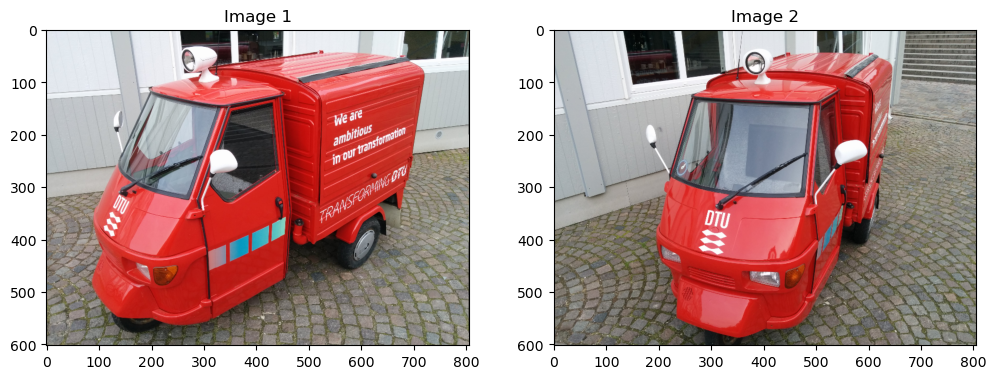

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.title("Image 1")
plt.subplot(1, 2, 2)
plt.imshow(im2)
plt.title("Image 2")
plt.show()
# Enable interactive mode for clicking
%matplotlib qt

# Function to handle mouse clicks and draw epipolar lines
def onclick(event):
    if event.inaxes == plt.gcf().axes[0]:  # Check if click is in the first image
        # Get the clicked point coordinates
        x, y = event.xdata, event.ydata
        print(f"Clicked point in Image 1: ({x}, {y})")

        # Convert the point to homogeneous coordinates
        q1 = np.array([x, y, 1])

        # Compute the epipolar line in Image 2
        l2 = F @ q1  # Epipolar line in Image 2 (homogeneous coordinates)

        # Display Image 2 with the epipolar line
        plt.figure()
        plt.imshow(im2)
        DrawLine(l2, im2.shape)
        plt.title("Epipolar Line in Image 2")
        plt.show()

        # Verify that the clicked point lies on the epipolar line
        q2 = np.array([x, y, 1])  # Assume the same point for verification
        error = q2.T @ l2  # Epipolar constraint: q2^T * F * q1 = 0
        print(f"Epipolar constraint error: {error}")

# Connect the click event to the function
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.title("Image 1")
plt.subplot(1, 2, 2)
plt.imshow(im2)
plt.title("Image 2")
plt.gcf().canvas.mpl_connect('button_press_event', onclick)
plt.show()

## Triangulation
Create a function triangulate. It should be able to triangulate a single 3D point that has been
seen by n different cameras. The function should take as input: a list of n pixel coordinates (q1, q2,
. . . , qn), and a list of n projection matrices (P1, P2, . . . , Pn), and should return the triangulation
of the point in 3D using the linear algorithm.
Test your function by defining a 3D point, project this point to the image planes of the two
cameras, and then triangulate it using the projection. Try reprojecting your estimated 3D point
to the cameras. Do you find the same 2D pixels?

In [21]:
def triangulate(pixel_coords: np.array, proj_matrices: np.array):
    """
    Given a list of pixel coordinates and projection matrices, triangulate to a common 3D point
    Args:
        pixel_coords (np.array): list of pixel coordinates
        proj_matrices (np.array): list of projection matrices

    Return:
        triangle (np.array): triangulated 3D point
    """
    n = pixel_coords.shape[0]
    # B_stack = []
    B_stack = np.zeros((n * 2, 4))
    for i in range(n):
        x, y = pixel_coords[i]
        proj_matrix = proj_matrices[i]
        B = np.asarray([proj_matrix[2, :] * x - proj_matrix[0, :], 
                        proj_matrix[2, :] * y - proj_matrix[1, :]])
        B_stack = np.vstack((B_stack, B))
    U, S, Vt = np.linalg.svd(B_stack)
    # Get the smallest vector
    print(f"Vt is {Vt}")
    triangle = Vt[-1, :]
    triangle /= triangle[-1]
    return triangle

In [ ]:
# Define a 3D point in homogeneous coordinates
Q_true = np.array([1, 2, 3, 1])  # [X, Y, Z, 1]

# Define two camera projection matrices
P1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])

P2 = np.array([[1, 0, 0, 1], [0, 1, 0, 1], [0, 0, 1, 1]])

# Project the 3D point onto the image planes
q1 = P1 @ Q_true  # Projection in camera 1
q2 = P2 @ Q_true  # Projection in camera 2

# Normalize to get pixel coordinates
q1 = q1[:2] / q1[2]
q2 = q2[:2] / q2[2]
# Prepare inputs for triangulate function
pixel_coords = np.array([q1, q2])  # Shape: (2, 2)
proj_matrices = np.array([P1, P2])  # Shape: (2, 3, 4)

# Triangulate the 3D point
Q_estimated = triangulate(pixel_coords, proj_matrices)

# Print results
print("True 3D point (Q_true):", Q_true)
print("Estimated 3D point (Q_estimated):", Q_estimated)

# Verify reprojection
q1_reprojected = Pi(P1 @ Q_estimated)
q2_reprojected = Pi(P2 @ Q_estimated)

# # Normalize reprojected points
# q1_reprojected = q1_reprojected[:2] / q1_reprojected[2]
# q2_reprojected = q2_reprojected[:2] / q2_reprojected[2]

print("Original pixel coordinates (q1, q2):", q1, q2)
print(
    "Reprojected pixel coordinates (q1_reprojected, q2_reprojected):",
    q1_reprojected,
    q2_reprojected,
)

(2,)
Vt is [[-0.41726678 -0.62829961  0.6250196  -0.20119278]
 [-0.82146154  0.5493263  -0.04346089 -0.1468084 ]
 [ 0.29055585  0.19186857  0.08638088 -0.93343564]
 [-0.25819889 -0.51639778 -0.77459667 -0.25819889]]
True 3D point (Q_true): [1 2 3 1]
Estimated 3D point (Q_estimated): [1. 2. 3. 1.]
Original pixel coordinates (q1, q2): [0.33333333 0.66666667] [0.5  0.75]
Reprojected pixel coordinates (q1_reprojected, q2_reprojected): [0.33333333 0.66666667] [0.5  0.75]
